## Packages

Setup multiprocessing (note that cluster needs to be activated)

In [1]:
import os
# from ipyparallel import Client
# rc = Client()
# dview = rc[:]

# number_of_engines = 8
# dview.map(os.chdir, [os.getcwd()]*number_of_engines)

In [2]:
# %%px --local
import numpy as np
import pandas as pd
import time
from sqr.core.network import local_graph
from sqr.main_assign import get_assignment, data_cols

In [3]:
from tqdm import tqdm
import geopandas as gpd
from sqr.core.scoring import partition_score
from sqr.core.shape import make_gdf_square_data

# Multiple engines

Make joblist

In [4]:
kommuner = gpd.read_file('data/shape/KOMMUNE.shp')

mun_pop_min = {}
mun_pop_avg = {}
mun_cell_count = {}

for idx in kommuner.index:
    mun_data = \
        pd.read_hdf('data/parsed/sqr_mun.hdf', key='sqidx%i'% idx)
    mun_pop_min[idx] = mun_data.minimum.sum()    
    mun_pop_avg[idx] = mun_data['mean'].sum()    
    mun_cell_count[idx] = mun_data.shape[0]
                
kommuner['minimum_total'] = pd.Series(mun_pop_min)
kommuner['mean_total'] = pd.Series(mun_pop_avg)
kommuner['cell_count'] = pd.Series(mun_cell_count)

kommuner['to_assign'] = kommuner.minimum_total>100

In [5]:
kommuner['density'] = kommuner['mean_total']/kommuner['cell_count']

In [ ]:
# selection = (kommuner.to_assign) & (kommuner.cell_count<5000) #& (kommuner.index<80)
selection = kommuner['density'].between(6, 9.999999)
selection.sum()

In [6]:
# outstore = pd.HDFStore(out_file)
# outstore.remove('munidx160')
# outstore.remove('munidx218')
# outstore.close()

### Main settings

In [7]:
# main info
level = 'submun'
mun_indices = kommuner[selection].index.tolist()

# additional info
trade = True
job_list = []
num_iter = 0

# get input/output references
if level == 'mun':
    in_file = 'data/parsed/sqr_mun.hdf' 
    out_file = 'data/candidates.hdf'
    
elif level == 'submun':    
    in_file = 'data/parsed/sqr_mun_sub.hdf'
    out_file = 'data/candidates_sub.hdf'
    
else:
    raise ValueError('Must specify level')

### Prepare input data

In [ ]:
# get references for input files and select
keys = pd.HDFStore(in_file).keys()    
keys = pd.DataFrame(data = [(k.split('_')[0][6:], k[6:], k[1:]) for k in keys], 
                    columns = ['mun_idx','idx','key'])    
keys = keys[keys.mun_idx.astype(int).isin(mun_indices)]

    
mun_pop = {}
mun_cell_count = {}

years = list(map(str,range(1986,2016)))

# load input for processing
for (i,row) in keys.iterrows():
    df = pd.read_hdf(in_file, key=row.key)        
    
    if df.shape[0]>1:
        try:
            accomplished = pd.read_hdf(out_file, key='munidx%s' % row.idx).shape[0]
            remain_num_iter = max(0, num_iter - accomplished)
            
        except:
            remain_num_iter = num_iter
        
        if remain_num_iter > 0:
            G = local_graph(df)
            big_G = local_graph(df, max_dist=3)
            
            pop_density = df[years].fillna(0).mean().mean()
            pop_count = df[years].sum(0).min()

            mun_pop[row.idx] = pop_count
            mun_cell_count[row.idx] = df.shape[0]

            if pop_count>=100:                
                job_list += [(row.idx,df,G,big_G,pop_density,trade) for _ in range(remain_num_iter)]

pd.np.random.shuffle(job_list)  
print(len(job_list))

### Execute joblist

In [40]:
dview.map_async(get_assignment, job_list)

<AsyncMapResult: get_assignment>

# Parse temporary files
Check for available files

In [ ]:
len(os.listdir('data/temp_output'))

Parse data

In [39]:
def file_loader(f):
    try:
        return pd.read_csv('data/temp_output/%s' % f)
    except:
        return pd.DataFrame()

In [ ]:
files = os.listdir('data/temp_output')
if len(files)>0:    
    output = pd.concat([file_loader(f) for f in files], axis=0)

    by_mun_idx = output.groupby('mun_idx')

    old_keys = [k[1:] for k in pd.HDFStore(out_file).keys()]

    for idx, df_input in by_mun_idx:        

#         print (idx)
        if ('munidx%s' % idx) in old_keys:
            existing = pd.read_hdf(out_file, key='munidx%s' % idx)
            output = pd\
                    .concat([df_input, existing])\
                    .drop_duplicates(subset=['finish_ts'])

        else:
            output = df_input
    #     get_undominated()
        output.to_hdf(out_file, key='munidx%s' % idx)

    print(len(files))
    for f in files: os.remove('data/temp_output/%s' % f)

In [ ]:
old_keys = [k[1:] for k in pd.HDFStore(out_file).keys()]

sum([pd.read_hdf(out_file, key=key).shape[0] for key in old_keys])

Move to clean hdf

In [57]:
args = tuple([os.getcwd()]+out_file.split('/'))

file_new = '%s/%s/%s' % args
file_old = '%s/%s/old_%s' % args

os.rename(file_new, file_old)

hdf_old = pd.HDFStore(file_old)
hdf_new = pd.HDFStore(file_new)
transfer_keys = hdf_old.keys()

for key in map(lambda s: s[1:],transfer_keys):
    hdf_old.get(key).to_hdf(file_new, key=key)
    
    
hdf_old.close()
os.remove(file_old)

Get output statistics

In [15]:
output_stat = []
for idx in kommuner.index:
    df = pd.read_hdf('data/parsed/sqr_mun.hdf', 'sqidx%i' % idx)
    if df.minimum.sum()>0:
        try:        
            run_info = pd.read_hdf('data/candidates.hdf', key='munidx%i' % idx)
            run_info_trade = run_info#[run_info.trade]
            if run_info_trade.shape[0]>0:
                output_stat.append([idx, run_info_trade.shape[0], run_info_trade.delta_t.median(),
                                    df.minimum.shape[0], int(df.minimum.sum())])
        except:
            runs = 0
#             output_stat.append([idx, runs, df.minimum.shape[0], int(df.minimum.sum())])

output_stat = pd.DataFrame(output_stat, columns=['idx','run_count','run_time' ,'cell_count','pop_count'])

Plot running time

(0, 25000.0)

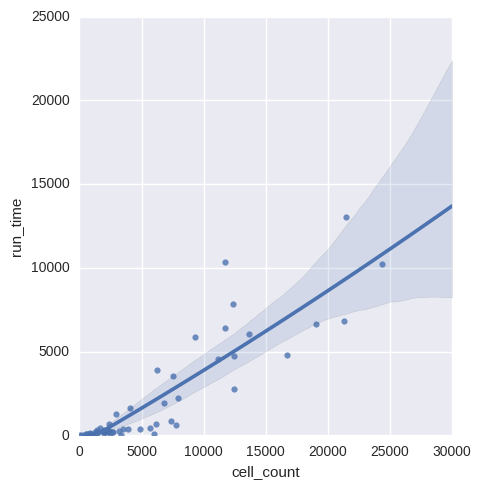

In [16]:
import seaborn as sns
%matplotlib inline

# output_stat['oko5'] = output_stat.cell_count>3000

fig = sns.lmplot(y='run_time',x='cell_count',order=2,data=output_stat)

sns.plt.xlim(0,)
sns.plt.ylim(0,)
# fig.savefig('runtime_cellcount.pdf')